### Debt Relief Challenge

James Fung

In [1]:
import pandas as pd
import numpy as np
from numpy import errstate,isneginf,array
import seaborn as sb
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

from nltk.corpus import stopwords
stop = stopwords.words('english')

pd.options.mode.chained_assignment = None  # default='warn'

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import math
import sklearn.metrics as sklm

from sklearn.linear_model import LinearRegression, Ridge

from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

/Users/jamesfung/anaconda3/lib/python3.6/site-packages/scipy/__init__.py:115: UserWarning: Numpy 1.13.3 or above is required for this version of scipy (detected version 1.12.1)
  UserWarning)
/Users/jamesfung/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
data = pd.read_csv("/Users/jamesfung/repos/side_projects/debt_relief/listings.csv")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48864 entries, 0 to 48863
Data columns (total 15 columns):
id                                48864 non-null int64
name                              48848 non-null object
host_id                           48864 non-null int64
host_name                         48846 non-null object
neighbourhood_group               48864 non-null object
neighbourhood                     48864 non-null object
latitude                          48864 non-null float64
longitude                         48864 non-null float64
room_type                         48864 non-null object
minimum_nights                    48864 non-null int64
calculated_host_listings_count    48864 non-null int64
availability_365                  48864 non-null int64
number_of_reviews                 48864 non-null int64
reviews_per_month                 38733 non-null float64
price                             48864 non-null int64
dtypes: float64(3), int64(7), object(5)
memory usage: 5

In [4]:
#Drop some unecessary columns
data = data.drop(['id','host_id','latitude','longitude'],axis=1)

Problem:

Given only this data, you want to create a model to predict how much you can charge for new listings while keeping vacancy down.   
Please put together a brief analysis of the dataset and show how you would go about creating a model to predict a listing price, while taking market demand into account. 

In [5]:
#Create a hold out set.
train, test = train_test_split(data,test_size=0.3)     

### Preliminary EDA

In [6]:
#Any missing values?
train.isnull().sum()

name                                13
host_name                           13
neighbourhood_group                  0
neighbourhood                        0
room_type                            0
minimum_nights                       0
calculated_host_listings_count       0
availability_365                     0
number_of_reviews                    0
reviews_per_month                 7176
price                                0
dtype: int64

Name and host_name seem reasonable to have missing information. Reviews per month could be missing if there are no reviews per month?

In [7]:
train[train.reviews_per_month.isna() == True].number_of_reviews.value_counts()

0    7176
Name: number_of_reviews, dtype: int64

In [8]:
#Fill in the NA values with 0.

train.reviews_per_month = train.reviews_per_month.fillna(value=0)
train.name = train.name.fillna(value='None')
train.host_name = train.name.fillna(value='None')

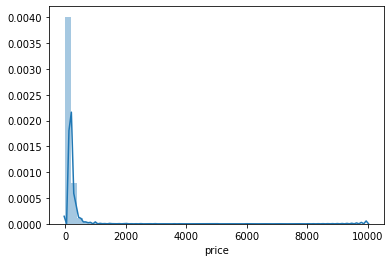

In [9]:
#What is the distribution of Y?

sb.distplot(train.price)

This is extremely right skewed, and also seems to contain some extreme outliers.

In [10]:
train.price.describe()

count    34204.000000
mean       151.216846
std        239.455157
min          0.000000
25%         69.000000
50%        105.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

In [11]:
#What is the correlation between then numerical values and price?
num=train.select_dtypes(exclude='object')
num.corr().price.to_frame().sort_values(by='price', ascending=False)

,price
price,1.000000
availability_365,0.077533
calculated_host_listings_count,0.058357
minimum_nights,0.042381
number_of_reviews,-0.044972
reviews_per_month,-0.051682


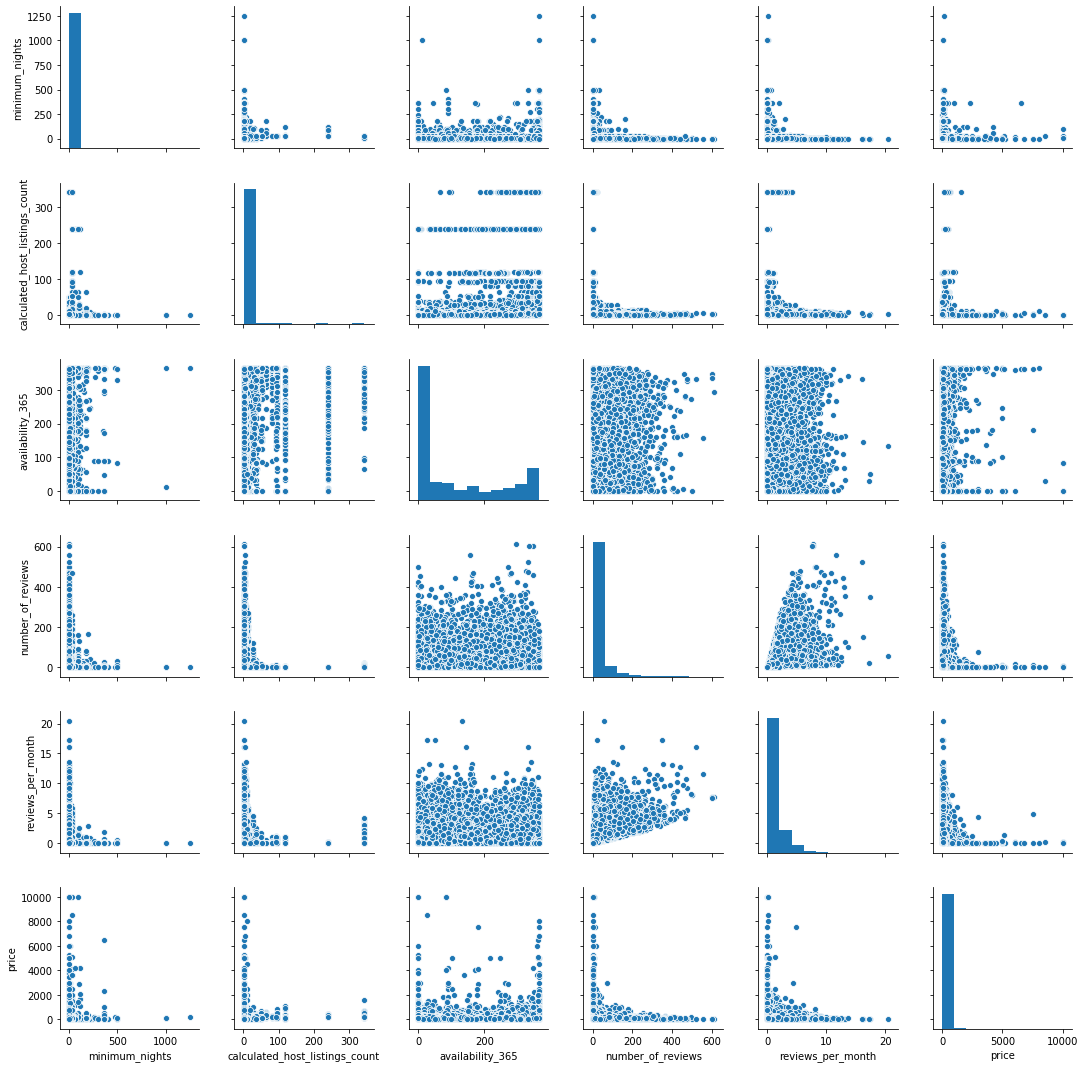

In [12]:
sb.pairplot(num)

There are extremely weak correlations between many of the numerical values and the final price due to the extreme skew of all of the variables.

In [13]:
num_log = num.transform([np.log])
num_log[isneginf(num_log)]=0
num_log.corr().price.sort_values(by='log',ascending=False)

,,log
price,log,1.000000
availability_365,log,0.088854
minimum_nights,log,0.075513
calculated_host_listings_count,log,0.016056
reviews_per_month,log,-0.001836
number_of_reviews,log,-0.052842


This helped very slightly in terms of correlation.

In [14]:
#What is the relationship between the categorical features and price?
train[['room_type','price']].groupby('room_type').median().sort_values(by='price', ascending=False)

,price
room_type,
Entire home/apt,160
Private room,70
Shared room,45


Not surprising that entire home/apt's are higher priced.

In [15]:
train[['neighbourhood_group','price']].groupby('neighbourhood_group').median().sort_values(by='price', ascending=False)

,price
neighbourhood_group,
Manhattan,150.0
Brooklyn,91.0
Staten Island,75.0
Queens,72.5
Bronx,65.0


Not surprising that Manhattan and Brooklyn are the most expensive.

In [16]:
neigh_counts = train.neighbourhood.value_counts().to_frame()
neigh_counts.tail(10)

,neighbourhood
Neponsit,1
Howland Hook,1
Westerleigh,1
Castleton Corners,1
Country Club,1
Rossville,1
Fort Wadsworth,1
West Farms,1
Holliswood,1
Woodrow,1


There are some extremely rare neighborhoods - these will probably be unimformative, won't help with our predictions, and increase the dimensionality of our data. Let's reclassify rare neighborhoods into 'other.'

In [17]:
def recat_val(data, col, num):
    data.loc[data[col].value_counts()[data[col]].values < num, col] = "Other"
    return data

In [18]:
train = recat_val(train, 'neighbourhood', 5)

In [19]:
train.neighbourhood.nunique()

185

In [20]:
train[['neighbourhood','price']].groupby('neighbourhood').mean().sort_values(by='price', ascending=False).head(10)

,price
neighbourhood,
Sea Gate,664.333333
Riverdale,554.857143
Tribeca,458.982456
Randall Manor,414.928571
Battery Park City,408.980769
Bay Terrace,344.000000
NoHo,313.810345
Flatiron District,301.490909
West Village,282.264151


There is definitely a relationship between neighbourhood and price - but this could definitely be due to the Manhattan, Brooklyn factor. It's interesting to note that Tribeca is nearly $200 more, on average, than Flatiron, Noho, Midtown. Neighborhood will most likely play an important role.

There are a few strange ones. I suspect that there are "outliers" i.e. people who price their homes higher than it should be in areas with less homes. Let's leave them in for now, as they are technically not errors.

Does the name play a role into the price? A hypothesis could be certain words could attract individuals to book. Let's do some simple text mining and create the name as a feature.

In [21]:
train['name_clean'] = train.name.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
train['name_clean'] = train.name_clean.str.lower()

In [22]:
#Let's create a list of certain words that could play a factor in price that is independent from the room type.
words = ['spacious','luxury',
         'large','backyard',
         'beautiful','stylish',
         'amazing','convenient',
         'sunny','big','cozy']

In [23]:
def contains_word(data, col, word):
    data[word] = np.where(data[col].str.contains(word) == True, 1, 0)
    return data

In [24]:
for word in words:
    train = contains_word(train, 'name_clean', word)

In [25]:
train = train.drop(['name','host_name','name_clean'],axis=1)
cat=train.select_dtypes(include='object')
cat_names = cat.columns

In [26]:
ohe = OneHotEncoder(handle_unknown = 'ignore')
ohe.fit(cat)
encoded_cat = pd.DataFrame(ohe.transform(cat).toarray(), columns = ohe.get_feature_names())

In [27]:
train = train.drop(cat.columns, axis=1)
train = train.reset_index(drop = True)
enocded_cat = encoded_cat.reset_index(drop = True)
train = pd.concat([train, encoded_cat], axis=1)
    
y_train = train.price.values
X_train = train.drop(['price'],axis=1).values

In [28]:
###Create a function to process the test data for modeling that mimics our processes from train .

def process_data_test(data):
    
    data.reviews_per_month = data.reviews_per_month.fillna(value=0)
    data.name = data.name.fillna(value='None')
    data.host_name = data.name.fillna(value='None')
    
    data['name_clean'] = data.name.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    data['name_clean'] = data.name_clean.str.lower()
    
    for word in words:
        data = contains_word(data, 'name_clean', word)
        
    data = data.drop(['name','host_name','name_clean'],axis=1)
    cat=data.select_dtypes(include='object')
    
    encoded_cat = pd.DataFrame(ohe.transform(cat).toarray(), columns = ohe.get_feature_names())
    data = data.drop(cat.columns, axis=1)
    data = data.reset_index(drop = True)
    enocded_cat = encoded_cat.reset_index(drop = True)
    data = pd.concat([data, encoded_cat], axis=1)
    
    y = data.price.values
    X = data.drop(['price'],axis=1).values
    
    return X, y

In [29]:
X_test, y_test = process_data_test(test)

### Modeling

In [30]:
### Because y is so skewed, we need to log transform it to be able to use certain error metrics, like MSE/RMSE.
y_train_log = np.log(y_train)
y_train_log[isneginf(y_train_log)]=0

/Users/jamesfung/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


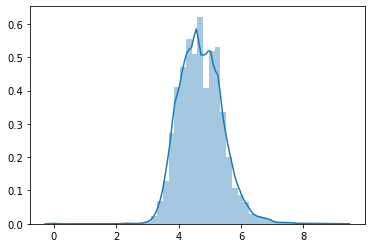

In [31]:
sb.distplot(y_train_log)

### Baseline RMSE - Regression

In [32]:
lreg=LinearRegression(n_jobs = -1)
MSEs=cross_val_score(lreg, X_train, y_train_log, scoring='neg_mean_squared_error', cv=5)
meanMSE=np.mean(MSEs)
print(meanMSE)
print('RMSE = '+str(math.sqrt(-meanMSE)))

-0.226207152883
RMSE = 0.4756123977393322


### Ridge Regression (L2)

In [33]:
ridge=Ridge()
parameters= {'alpha':[x for x in range(1,101)]}

ridge_reg=RandomizedSearchCV(ridge, 
                             param_distributions=parameters, 
                             scoring='neg_mean_squared_error', 
                             cv=15)

ridge_reg.fit(X_train,y_train_log)

print("The best value of Alpha is: ",ridge_reg.best_params_)
print("The best score achieved with Alpha=11 is: ",math.sqrt(-ridge_reg.best_score_))

ridge_pred=math.sqrt(-ridge_reg.best_score_)

The best value of Alpha is:  {'alpha': 8}
The best score achieved with Alpha=11 is:  0.4747647770508169


In [53]:
ridge_mod=Ridge(alpha=8)
ridge_mod.fit(X_train,y_train_log)

y_pred_train=ridge_mod.predict(X_train)

print('Root Mean Square Error train = ' + str(math.sqrt(sklm.mean_squared_error(y_train_log, y_pred_train))))

Root Mean Square Error train = 0.47201460714251603


A bit better than above.

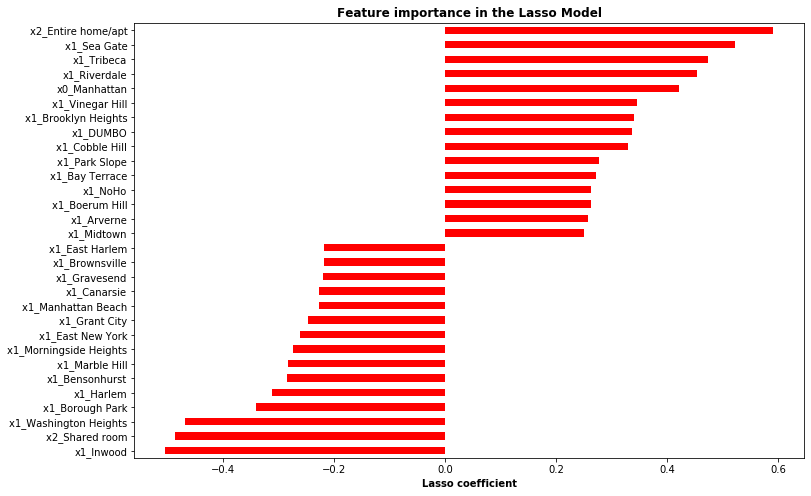

In [54]:
coefs = pd.Series(ridge_mod.coef_, index = train.loc[:, train.columns != 'price'].columns)

imp_coefs = pd.concat([coefs.sort_values().head(15),
                     coefs.sort_values().tail(15)])
imp_coefs.plot(kind = "barh", color='red')
plt.xlabel("Lasso coefficient", weight='bold')
plt.title("Feature importance in the Lasso Model", weight='bold')

rcParams['figure.figsize'] = 11, 8

plt.show()

This aligns closely to what the conlcusions we made earlier.

### Bagging w/Random Forest

Set up two Random Forests - one with base parameters and one with hyperparmeters to see if tuning helps with model performance.

In [36]:
base_rf = RandomForestRegressor(random_state = 42)

MSEs=cross_val_score(base_rf, X_train, y_train_log, scoring='neg_mean_squared_error', cv=5)
meanMSE=np.mean(MSEs)
print(meanMSE)
print('RMSE = '+str(math.sqrt(-meanMSE)))

-0.215265259165
RMSE = 0.4639668729178344


Slightly better than the above regression.

In [37]:
rf = RandomForestRegressor(random_state = 42)

In [38]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]

max_features = ['auto', 'sqrt']

max_depth = [int(x) for x in np.linspace(3, 10, num = 11)] #Keep this relatively shallow for performance reasons.
max_depth.append(None)


min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

To save some time, let's just do a few iterations.

In [39]:
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 5, cv = 3, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1)
rf_random.fit(X_train, y_train_log)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  6.9min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [40]:
rf_random.best_params_

{'n_estimators': 911,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 9}

In [41]:
y_pred_train=rf_random.predict(X_train)
print('Root Mean Square Error train = ' + str(math.sqrt(sklm.mean_squared_error(y_train_log, y_pred_train))))

Root Mean Square Error train = 0.4391110083453866


This is better than above by .03.

In [42]:
#Produce the feature importance list.
rf_best = RandomForestRegressor(random_state = 42,
                                n_estimators= 911,
                                min_samples_split= 5,
                                min_samples_leaf= 1,
                                max_features= 'auto',
                                max_depth= 9)

rf_best.fit(X_train, y_train_log)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=9, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=911, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

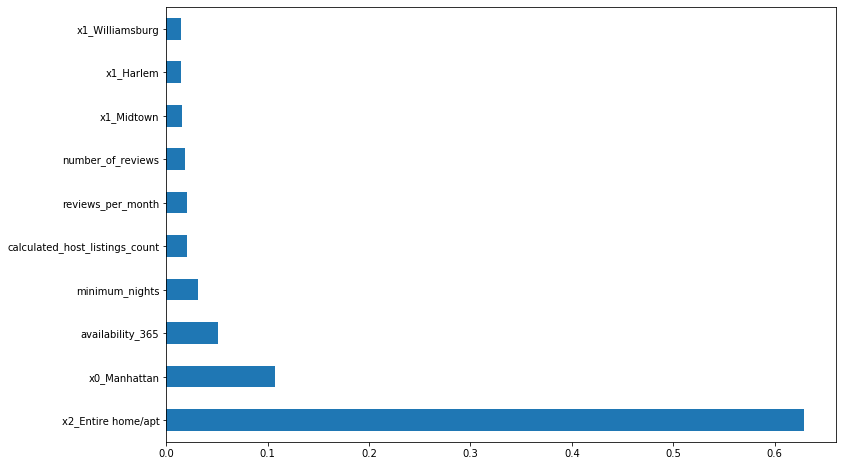

In [43]:
feat_importances = pd.Series(rf_best.feature_importances_, index = train.loc[:, train.columns != 'price'].columns)
feat_importances.nlargest(10).plot(kind='barh')

Random Forest places a lot more emphasis on the entire home. It's interesting to note that the top 10 features are much different than the prior regularized regression. I would imagine if I used SHAP values or permutation feature importance the results may be different.

### Boosting w/LightGBM

In [44]:
d_train = lgb.Dataset(X_train, label=y_train_log)

#LightGBM has quite a bit of parameters, let's just try a basic one with 5000 iterations to see if it performs better than RF.

params = {}
params['learning_rate'] = 0.003
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'mean_squared_error'
params['sub_feature'] = 0.5
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 10
gbm = lgb.train(params, d_train, 5000)

In [45]:
y_pred_train=gbm.predict(X_train)
print('Root Mean Square Error train = ' + str(math.sqrt(sklm.mean_squared_error(y_train_log, y_pred_train))))

Root Mean Square Error train = 0.4429668184344969


LightGBM could potentially perform better given some parameter tuning and using early stopping.

### Out of Sample Evaulation

In [46]:
y_test_log = np.log(y_test)
y_test_log[isneginf(y_test_log)]=0

In [55]:
y_test_pred = ridge_reg.predict(X_test)
print('Root Mean Square Error test = ' + str(math.sqrt(sklm.mean_squared_error(y_test_log, y_test_pred))))

Root Mean Square Error test = 0.47066796943987615


In [48]:
y_test_pred = rf_best.predict(X_test)
print('Root Mean Square Error test = ' + str(math.sqrt(sklm.mean_squared_error(y_test_log, y_test_pred))))

Root Mean Square Error test = 0.46308433038890434


In [50]:
y_test_pred = gbm.predict(X_test)
print('Root Mean Square Error test = ' + str(math.sqrt(sklm.mean_squared_error(y_test_log, y_test_pred))))

Root Mean Square Error test = 0.4464506927300599


Not surprised that a boosted method performed the best out of sample (due to shallower trees in boosting methods.) It would potentially perform even better with hyperparameter tuning.

In [51]:
rev_pred = np.exp(y_test_pred) ##reverse the logarithmic from earlier to get prices

In [52]:
###Use absolute error to understand from a real world perspective the error in dollars.
print('Light GBM Mean Absolute Error = ' + str(sklm.mean_absolute_error(rev_pred, y_test)))

Light GBM Mean Absolute Error = 56.6274487988


A MAE of $56 is not too bad. I would imagine AirBnb has lots more data on their homes (such as dates for seasonality) that could improve model performance.